In [5]:
# Imports
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

%pip install apyori
from apyori import apriori
!pip install prince
import prince

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
%pip install seaborn
import seaborn as sns
from mlxtend.preprocessing import TransactionEncoder
from matplotlib.lines import Line2D

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [6]:
# Paths
NB   = Path.cwd()          # notebook folder
PROJ = NB.parent           # Project/
DATA = PROJ / "data"       # Project/data/
OUT  = PROJ / "outputs"    # Project/outputs/
FIGS = OUT / "figures"     # Project/outputs/figures
TABS = OUT / "tables"      # Project/outputs/tables
for p in (OUT, FIGS, TABS):  # make folders if missing
    p.mkdir(parents=True, exist_ok=True)

CSV_PATH = DATA / "styles.csv"   # central place for the dataset path

In [8]:
# Load Dataset
styles = pd.read_csv(CSV_PATH, on_bad_lines="skip")
styles.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [59]:
styles.columns

Index(['id', 'gender', 'masterCategory', 'subCategory', 'articleType',
       'baseColour', 'season', 'year', 'usage', 'productDisplayName'],
      dtype='object')

In [60]:
styles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44424 entries, 0 to 44423
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  44424 non-null  int64  
 1   gender              44424 non-null  object 
 2   masterCategory      44424 non-null  object 
 3   subCategory         44424 non-null  object 
 4   articleType         44424 non-null  object 
 5   baseColour          44409 non-null  object 
 6   season              44403 non-null  object 
 7   year                44423 non-null  float64
 8   usage               44107 non-null  object 
 9   productDisplayName  44417 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 3.4+ MB


In [61]:
styles.head(20)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt
5,1855,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011.0,Casual,Inkfruit Mens Chain Reaction T-shirt
6,30805,Men,Apparel,Topwear,Shirts,Green,Summer,2012.0,Ethnic,Fabindia Men Striped Green Shirt
7,26960,Women,Apparel,Topwear,Shirts,Purple,Summer,2012.0,Casual,Jealous 21 Women Purple Shirt
8,29114,Men,Accessories,Socks,Socks,Navy Blue,Summer,2012.0,Casual,Puma Men Pack of 3 Socks
9,30039,Men,Accessories,Watches,Watches,Black,Winter,2016.0,Casual,Skagen Men Black Watch


In [62]:
# Cleaning
styles = styles.copy()

# lowercase & strip spaces
styles = styles.applymap(lambda x: str(x).strip().lower() if isinstance(x, str) else x)

# fill missing categorical values
styles.fillna("unknown", inplace=True)

# extract bran & style hints from productDisplayName
styles["brand"] = styles["productDisplayName"].str.extract(r"(^\w+)")
styles["style_word"] = styles["productDisplayName"].str.extract(
    r"(shirt|jean|kurta|shoe|dress|coat|top|t-shirt|jacket|sandal|bag|wallet)"
)

/var/folders/wl/_7llws2n58z1nsx2yh_qqxdh0000gn/T/ipykernel_37864/3828952801.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  styles = styles.applymap(lambda x: str(x).strip().lower() if isinstance(x, str) else x)
/var/folders/wl/_7llws2n58z1nsx2yh_qqxdh0000gn/T/ipykernel_37864/3828952801.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'unknown' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  styles.fillna("unknown", inplace=True)


In [63]:
# Pick the columns you want to treat as "items" in each basket (product)
cols = ['gender','articleType', 'baseColour', 'season'] #removed masterCategory & subCategory & year from list

# Make everything strings and drop rows with all-missing in these cols
subset = styles[cols].astype(str).fillna('NA')

# Each transaction is a SET of attribute values for a single product
transactions = [set(row) for row in subset.itertuples(index=False, name=None)]
len(transactions), transactions[0]

(44424, {'fall', 'men', 'navy blue', 'shirts'})

In [64]:
# Tune thresholds to taste (start a bit low to see results)
association_results = list(apriori(
    transactions,
    min_support=0.01,        # 1% of products
    min_confidence=0.2,      # 20% confidence
    min_lift=1.0,
    max_length=3             # keep rules short; bump to 4 if you want
))

print(f"Generated {len(association_results)} rules")

Generated 164 rules


In [65]:
for rule in association_results[:25]:  # show first 25 (sorted comes below)
    items = [x for x in rule.items]
    print("Rule:", " & ".join(items[:-1]) if len(items) > 1 else items[0], "->", items[-1])
    print("Support:", rule.support)
    print("Confidence:", rule.ordered_statistics[0].confidence)
    print("Lift:", rule.ordered_statistics[0].lift)
    print("=====================================")

Rule: black -> black
Support: 0.21898073113632271
Confidence: 0.21898073113632271
Lift: 1.0
Rule: fall -> fall
Support: 0.25731586529803707
Confidence: 0.25731586529803707
Lift: 1.0
Rule: men -> men
Support: 0.4985368269403926
Confidence: 0.4985368269403926
Lift: 1.0
Rule: summer -> summer
Support: 0.48334233747523864
Confidence: 0.48334233747523864
Lift: 1.0
Rule: women -> women
Support: 0.41939041959301276
Confidence: 0.41939041959301276
Lift: 1.0
Rule: unisex -> backpacks
Support: 0.014204033855573563
Confidence: 0.8715469613259669
Lift: 17.916521152218767
Rule: beige -> women
Support: 0.01136772915541149
Confidence: 0.6742323097463284
Lift: 1.607648334934834
Rule: men -> belts
Support: 0.012178101926886368
Confidence: 0.6654366543665436
Lift: 1.334779335060249
Rule: summer -> belts
Support: 0.01220061228164956
Confidence: 0.6666666666666666
Lift: 1.3792846497764528
Rule: black -> casual shoes
Support: 0.019696560417792185
Confidence: 0.3075571177504393
Lift: 1.404493976042919
Rule:

In [66]:
# Top frequent itemsets (by support)
freq_itemsets = [(tuple(r.items), r.support) for r in association_results]
sorted_freq_itemsets = sorted(freq_itemsets, key=lambda x: x[1], reverse=True)

freq_df = pd.DataFrame(sorted_freq_itemsets, columns=['Items', 'Support'])
freq_df.head(15)

,Items,Support
0,"(men,)",0.498537
1,"(summer,)",0.483342
2,"(women,)",0.419390
3,"(fall,)",0.257316
4,"(men, summer)",0.244778
5,"(black,)",0.218981
6,"(fall, men)",0.159216
7,"(black, men)",0.132383
8,"(men, tshirts)",0.118022
9,"(winter, women)",0.103975


In [67]:
rows = []
for r in association_results:
    for stat in r.ordered_statistics:
        rows.append({
            "antecedent": tuple(stat.items_base),
            "consequent": tuple(stat.items_add),
            "support": r.support,
            "confidence": stat.confidence,
            "lift": stat.lift
        })

rules_df = pd.DataFrame(rows)
rules_df.sort_values(["lift", "confidence", "support"], ascending=False).head(20)

,antecedent,consequent,support,confidence,lift
5,"(backpacks,)","(unisex,)",0.014204,0.871547,17.916521
6,"(unisex,)","(backpacks,)",0.014204,0.291994,17.916521
81,"(perfume and body mist,)","(spring,)",0.013799,1.000000,14.892390
82,"(spring,)","(perfume and body mist,)",0.013799,0.205498,14.892390
273,"(winter, white)","(watches,)",0.012628,0.633183,11.065505
270,"(watches,)","(winter, white)",0.012628,0.220692,11.065505
252,"(watches,)","(winter, men)",0.032145,0.561762,7.733416
254,"(winter, men)","(watches,)",0.032145,0.442516,7.733416
213,"(heels,)","(winter, women)",0.022983,0.771731,7.422250
216,"(winter, women)","(heels,)",0.022983,0.221044,7.422250


In [68]:
# Split Dataset into Seasons

# normalize season text
styles['season'] = styles['season'].astype(str).str.strip().str.lower()

# keep only four main seasons
styles['season'] = styles['season'].replace({
    'spring/summer': 'summer',
    'fall/winter': 'winter'
})
styles['season'] = styles['season'].replace({
    'na': 'unknown',
    'nan': 'unknown'
})
styles['season'].value_counts()

season
summer     21472
fall       11431
winter      8517
spring      2983
unknown       21
Name: count, dtype: int64

In [69]:
styles_summer = styles[styles['season'] == 'summer']
styles_winter = styles[styles['season'] == 'winter']
styles_spring = styles[styles['season'] == 'spring']
styles_fall   = styles[styles['season'] == 'fall']

In [70]:
cols = ['gender','articleType', 'baseColour', 'season'] #removed masterCategory & subCategory & year from list

def build_transactions(df):
    subset = df[cols].astype(str).fillna('na')
    return [set(r) for r in subset.itertuples(index=False, name=None)]

transactions_summer = build_transactions(styles_summer)
transactions_winter = build_transactions(styles_winter)
transactions_spring = build_transactions(styles_spring)
transactions_fall   = build_transactions(styles_fall)

In [71]:
def run_apriori(transactions, label):
    print(f"\nRunning Apriori for {label}...")
    rules = list(apriori(
        transactions,
        min_support=0.01,     # tweak per season if too few/many
        min_confidence=0.2,
        min_lift=1.0,
        max_length=3
    ))
    print("Number of rules:", len(rules))
    # convert to itemsets
    itemsets = [(tuple(r.items), r.support) for r in rules if len(r.items) > 1]
    df = pd.DataFrame(itemsets, columns=['items','support']).sort_values('support', ascending=False)
    return df

freq_summer = run_apriori(transactions_summer, "Summer")
freq_winter = run_apriori(transactions_winter, "Winter")
freq_spring = run_apriori(transactions_spring, "Spring")
freq_fall   = run_apriori(transactions_fall,   "Fall")


Running Apriori for Summer...
Number of rules: 163

Running Apriori for Winter...
Number of rules: 159

Running Apriori for Spring...
Number of rules: 194

Running Apriori for Fall...
Number of rules: 168


In [72]:
topN = 25
summer_sets = set(freq_summer.head(topN)['items'])
winter_sets = set(freq_winter.head(topN)['items'])
spring_sets = set(freq_spring.head(topN)['items'])
fall_sets   = set(freq_fall.head(topN)['items'])

# Example: Jaccard Similarity (how much overlap)
intersection = len(summer_sets.intersection(winter_sets))
union = len(summer_sets.union(winter_sets))
similarity = intersection / union if union else 0
print(f"Summer vs Winter Jaccard Similarity: {similarity:.2f}")

Summer vs Winter Jaccard Similarity: 0.02


In [73]:
print("Top Summer Itemsets:")
display(freq_summer.head(10))

print("Top Winter Itemsets:")
display(freq_winter.head(10))

print("Top Spring Itemsets:")
display(freq_spring.head(10))

print("Top Fall Itemsets:")
display(freq_fall.head(10))

Top Summer Itemsets:


,items,support
53,"(men, summer)",0.506427
83,"(women, summer)",0.392791
10,"(black, summer)",0.208225
79,"(summer, tshirts)",0.204219
55,"(men, tshirts)",0.143210
140,"(men, summer, tshirts)",0.143210
82,"(white, summer)",0.132219
96,"(black, men, summer)",0.128353
8,"(black, men)",0.128353
15,"(summer, blue)",0.117688


Top Winter Itemsets:


,items,support
77,"(winter, women)",0.542327
51,"(winter, men)",0.378889
12,"(winter, black)",0.299988
74,"(winter, watches)",0.290478
49,"(men, watches)",0.167665
136,"(winter, men, watches)",0.167665
8,"(black, men)",0.155689
93,"(winter, black, men)",0.155689
24,"(winter, brown)",0.128332
68,"(winter, sunglasses)",0.121991


Top Spring Itemsets:


,items,support
95,"(spring, women)",0.640630
66,"(men, spring)",0.323500
78,"(perfume and body mist, spring)",0.205498
9,"(black, spring)",0.137781
26,"(deodorant, spring)",0.114985
16,"(spring, brown)",0.111297
62,"(men, perfume and body mist)",0.110962
160,"(men, perfume and body mist, spring)",0.110962
173,"(spring, women, nail polish)",0.109286
71,"(women, nail polish)",0.109286


Top Fall Itemsets:


,items,support
28,"(fall, men)",0.618756
49,"(fall, women)",0.320182
46,"(fall, tshirts)",0.219403
4,"(black, fall)",0.200070
69,"(men, tshirts)",0.176887
134,"(fall, men, tshirts)",0.176887
37,"(fall, shirts)",0.156154
128,"(fall, shirts, men)",0.146356
63,"(men, shirts)",0.146356
8,"(fall, blue)",0.139270


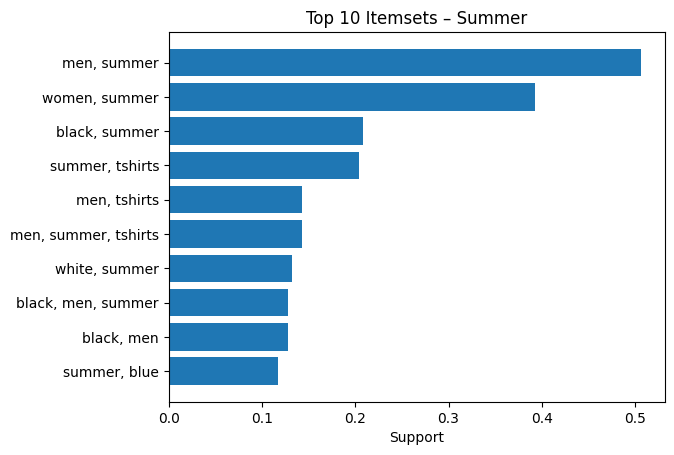

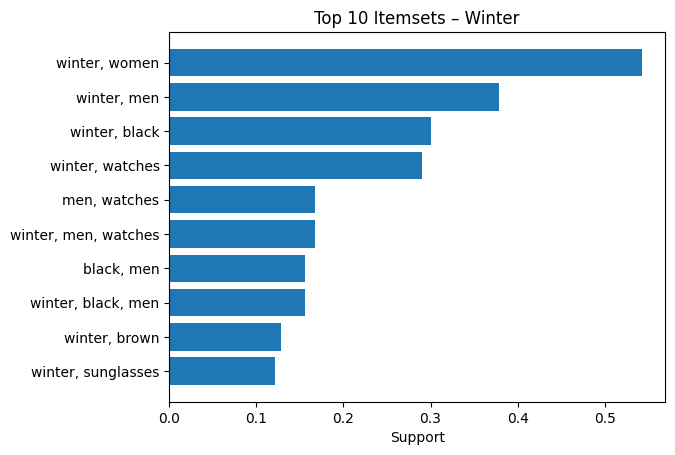

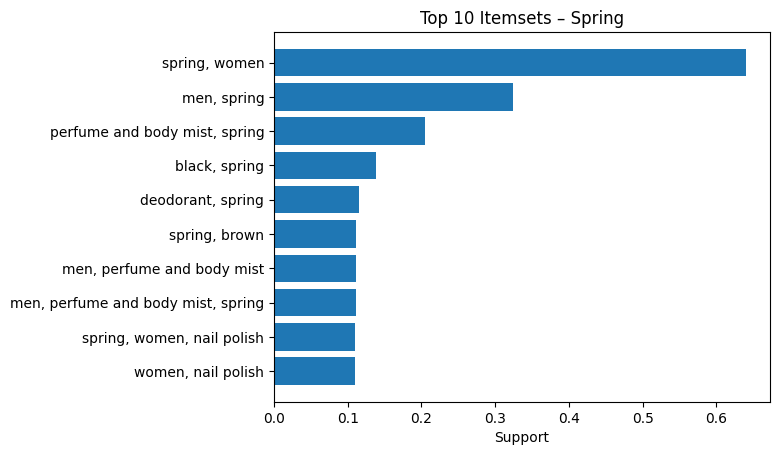

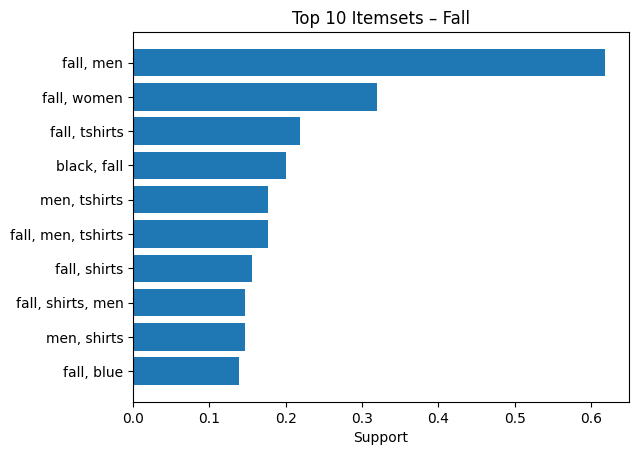

In [74]:
def plot_top(df, label, n=10):
    plt.barh(range(n), df['support'].head(n)[::-1])
    plt.yticks(range(n), [", ".join(i) for i in df['items'].head(n)][::-1])
    plt.xlabel('Support')
    plt.title(f'Top {n} Itemsets – {label}')
    plt.show()

plot_top(freq_summer, 'Summer')
plot_top(freq_winter, 'Winter')
plot_top(freq_spring, 'Spring')
plot_top(freq_fall, 'Fall')

In [75]:
summer_sets = set(freq_summer.head(25)['items'])
winter_sets = set(freq_winter.head(25)['items'])
jaccard = len(summer_sets & winter_sets) / len(summer_sets | winter_sets)
print(f"Jaccard Similarity (Summer vs Winter): {jaccard:.2f}")

Jaccard Similarity (Summer vs Winter): 0.02


In [76]:
## Multiple Correspondence Analysis (MCA)

cols = ['gender', 'subCategory', 'articleType', 'baseColour', 'season']
df_mca = styles[cols].dropna().astype(str)
df_mca.head()

,gender,subCategory,articleType,baseColour,season
0,men,topwear,shirts,navy blue,fall
1,men,bottomwear,jeans,blue,summer
2,women,watches,watches,silver,winter
3,men,bottomwear,track pants,black,fall
4,men,topwear,tshirts,grey,summer


In [77]:
df_mca = df_mca[df_mca['season'] != 'unknown']

mca = prince.MCA(
    n_components=2,       # 2D projection
    n_iter=3,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
)

mca = mca.fit(df_mca)
mca_coords = mca.transform(df_mca)
mca_coords.head()

In [78]:
cols = ['gender', 'articleType', 'baseColour', 'season']
df_mca = styles[cols].dropna().astype(str)
df_mca = df_mca[df_mca['season'] != 'unknown']

In [79]:
mca = prince.MCA(
    n_components=2,
    n_iter=3,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
)

mca = mca.fit(df_mca)
mca_coords = mca.transform(df_mca)
mca_coords.head()

,0,1
0,-0.848097,-0.422302
1,-0.561319,-0.232005
2,1.171120,1.637228
3,-0.673142,-0.038840
4,-0.749512,-0.296914


In [80]:
# coordinates for each CATEGORY level
col_coords = mca.column_coordinates(df_mca)

# we only want categories that help the narrative
keep_prefixes = ["season__", "gender__"]

common_article_types = [
    "tshirts", "shirts", "dress", "kurta", "trousers",
    "jackets", "shoes", "sweaters"
]
common_colours = ["black", "white", "blue", "red", "green", "multi"]

keep_indices = []
for idx in col_coords.index:
    if any(idx.startswith(p) for p in keep_prefixes):
        keep_indices.append(idx)
    elif idx.startswith("articleType__"):
        name = idx.split("__", 1)[1]
        if name in common_article_types:
            keep_indices.append(idx)
    elif idx.startswith("baseColour__"):
        name = idx.split("__", 1)[1]
        if name in common_colours:
            keep_indices.append(idx)

plot_coords = col_coords.loc[keep_indices].copy()

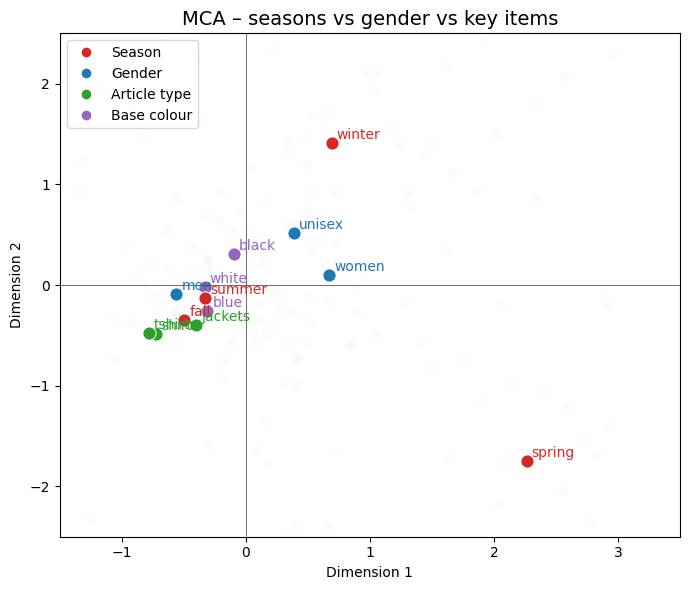

In [81]:
# 1) get all category coords
col_coords = mca.column_coordinates(df_mca)

# 2) define exactly which ones to show (tiny, intentional set)
show_these = [
    # seasons
    "season__summer",
    "season__winter",
    "season__spring",
    "season__fall",
    # gender
    "gender__men",
    "gender__women",
    "gender__unisex",
    # a few article types
    "articleType__tshirts",
    "articleType__shirts",
    "articleType__dress",
    "articleType__jackets",
    # a few base colours
    "baseColour__black",
    "baseColour__white",
    "baseColour__blue",
]

plot_coords = col_coords.loc[col_coords.index.intersection(show_these)].copy()

# 3) make a clean figure
plt.figure(figsize=(7, 6))

# (optional) very faint background for context
plt.scatter(col_coords[0], col_coords[1], alpha=0.02, color="gray")

def get_color(idx):
    if idx.startswith("season__"):
        return "#d62728"  # red
    if idx.startswith("gender__"):
        return "#1f77b4"  # blue
    if idx.startswith("articleType__"):
        return "#2ca02c"  # green
    if idx.startswith("baseColour__"):
        return "#9467bd"  # purple
    return "black"

for idx, row in plot_coords.iterrows():
    x, y = float(row[0]), float(row[1])
    c = get_color(idx)
    label = idx.split("__", 1)[1]
    plt.scatter(x, y, color=c, s=90, edgecolor="white", linewidth=0.7)
    plt.text(x + 0.04, y + 0.04, label, fontsize=10, color=c)

# axes & limits (zoom in!)
plt.axhline(0, color="black", linewidth=0.4)
plt.axvline(0, color="black", linewidth=0.4)

plt.xlim(-1.5, 3.5)   # <— zoom so spring/winter don’t look far away
plt.ylim(-2.5, 2.5)

plt.title("MCA – seasons vs gender vs key items", fontsize=14)
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")

legend_elems = [
    Line2D([0], [0], marker='o', color='w', label='Season', markerfacecolor='#d62728', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Gender', markerfacecolor='#1f77b4', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Article type', markerfacecolor='#2ca02c', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Base colour', markerfacecolor='#9467bd', markersize=8),
]
plt.legend(handles=legend_elems, loc="upper left")

plt.tight_layout()
plt.show()

In [82]:
eigvals = mca.eigenvalues_
total = eigvals.sum()
print("MCA dimension contributions:")
for i, v in enumerate(eigvals, start=1):
    print(f"  Dim {i}: {v:.3f} ({v/total:.1%})")

MCA dimension contributions:
  Dim 1: 0.544 (53.3%)
  Dim 2: 0.478 (46.7%)


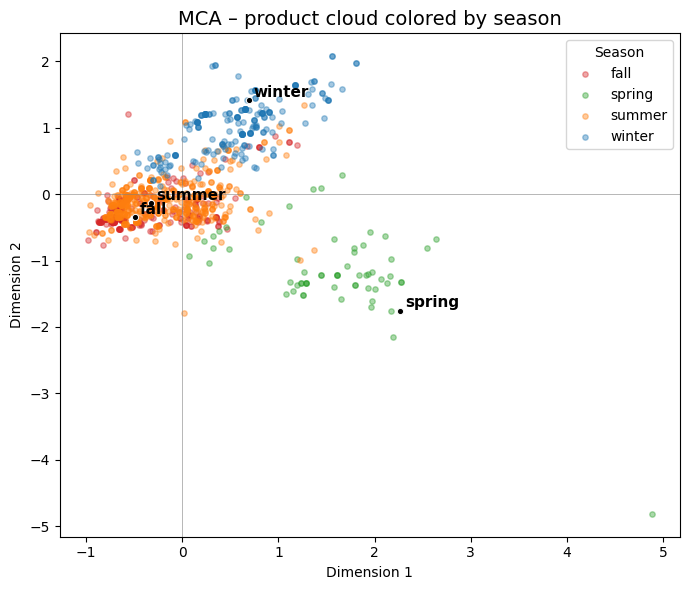

In [83]:
# 1) get the 2D coords for each product (you already have mca_coords)
coords = mca_coords.copy()
coords.columns = ['dim1', 'dim2']  # name the cols
coords['season'] = df_mca['season'].values

# 2) sample so it's readable
sample = coords.sample(1000, random_state=42)

# 3) get the season category coordinates (from column coords)
col_coords = mca.column_coordinates(df_mca)
season_pts = col_coords.loc[
    col_coords.index.isin([
        "season__summer",
        "season__winter",
        "season__spring",
        "season__fall"
    ])
]

plt.figure(figsize=(7, 6))

# scatter the products, colored by their season
palette = {
    'summer': '#ff7f0e',
    'winter': '#1f77b4',
    'spring': '#2ca02c',
    'fall':   '#d62728'
}

for s, group in sample.groupby('season'):
    plt.scatter(group['dim1'], group['dim2'],
                label=s, s=15, alpha=0.4,
                color=palette.get(s, 'gray'))

# overlay the season category points (bigger)
for idx, row in season_pts.iterrows():
    x, y = float(row[0]), float(row[1])
    label = idx.split("__", 1)[1]
    plt.scatter(x, y, color='black', s=20, edgecolor='white', linewidth=0.7)
    plt.text(x + 0.05, y + 0.05, label, fontsize=11, weight='bold')

plt.axhline(0, color='gray', linewidth=0.4)
plt.axvline(0, color='gray', linewidth=0.4)
plt.title("MCA – product cloud colored by season", fontsize=14)
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend(title="Season", loc="best")
plt.tight_layout()
plt.show()

In [84]:
cols = ['gender','subCategory','articleType','baseColour','season']
subset = styles[cols].astype(str).fillna('na')

transactions = subset.values.tolist()   # list of lists
len(transactions), transactions[0]

(44424, ['men', 'topwear', 'shirts', 'navy blue', 'fall'])

In [85]:
from mlxtend.preprocessing import TransactionEncoder
import pandas as pd

te = TransactionEncoder()
te_array = te.fit(transactions).transform(transactions)

X = pd.DataFrame(te_array, columns=te.columns_)  # this is your 0/1 matrix
X.head()

,accessories,accessory gift set,apparel set,baby dolls,backpacks,bags,bangle,basketballs,bath and body,bath robe,...,waist pouch,waistcoat,wallets,watches,water bottle,white,winter,women,wristbands,yellow
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,True,True,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [86]:
# reduce dimensionality with PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=10, random_state=42)
X_pca = pca.fit_transform(X)

print("Explained variance ratio per component:")
print(pca.explained_variance_ratio_)
print("Total variance captured:", pca.explained_variance_ratio_.sum())

Explained variance ratio per component:
[0.13964024 0.10533445 0.09290164 0.05290548 0.04683147 0.04116845
 0.03052048 0.02834786 0.02820374 0.02570232]
Total variance captured: 0.5915561254418019


In [87]:
results = []
for k in range(2, 9):
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = km.fit_predict(X_pca)
    score = silhouette_score(X_pca, labels)
    results.append((k, score))
    print(f"[PCA] k={k}, silhouette={score:.3f}")


[PCA] k=2, silhouette=0.213
[PCA] k=3, silhouette=0.215
[PCA] k=4, silhouette=0.208
[PCA] k=5, silhouette=0.234
[PCA] k=6, silhouette=0.229
[PCA] k=7, silhouette=0.235
[PCA] k=8, silhouette=0.277


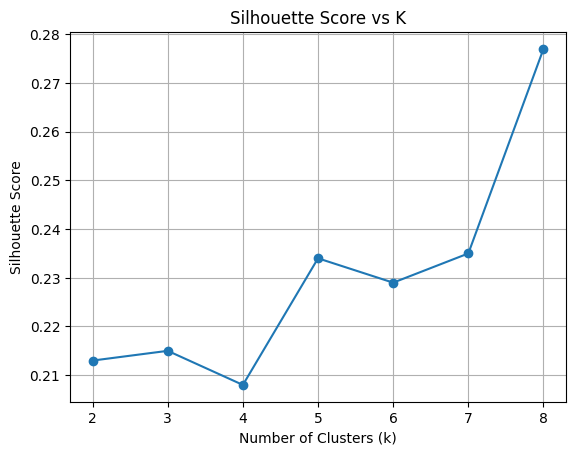

In [88]:
k_values = [2,3,4,5,6,7,8]
scores = [0.213, 0.215, 0.208, 0.234, 0.229, 0.235, 0.277]

plt.plot(k_values, scores, marker='o')
plt.title("Silhouette Score vs K")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()


In [89]:
best_k = 8
km = KMeans(n_clusters=best_k, random_state=42, n_init='auto')
labels = km.fit_predict(X_pca)

styles_clustered = styles.copy()
styles_clustered['cluster'] = labels

In [90]:
for c in range(best_k):
    sub = styles_clustered[styles_clustered['cluster'] == c]
    print(f"\n=== Cluster {c} ===")
    print("size:", len(sub))
    print("top genders:\n", sub['gender'].value_counts().head(5))
    print("top seasons:\n", sub['season'].value_counts().head(5))
    print("top article types:\n", sub['articleType'].value_counts().head(5))
    print("top colours:\n", sub['baseColour'].value_counts().head(5))


=== Cluster 0 ===
size: 3494
top genders:
 gender
men       3348
unisex     145
boys         1
Name: count, dtype: int64
top seasons:
 season
winter    3302
spring     192
Name: count, dtype: int64
top article types:
 articleType
watches         1497
sunglasses       631
casual shoes     331
formal shoes     157
wallets          128
Name: count, dtype: int64
top colours:
 baseColour
black     1664
brown      457
white      334
silver     152
grey       143
Name: count, dtype: int64

=== Cluster 1 ===
size: 9281
top genders:
 gender
women     8179
unisex     774
girls      205
boys       123
Name: count, dtype: int64
top seasons:
 season
summer     5915
spring     1995
fall       1364
unknown       7
Name: count, dtype: int64
top article types:
 articleType
handbags     1091
dresses       434
sarees        426
backpacks     381
bra           332
Name: count, dtype: int64
top colours:
 baseColour
black    1483
blue      954
white     798
pink      756
brown     657
Name: count, dtype: i

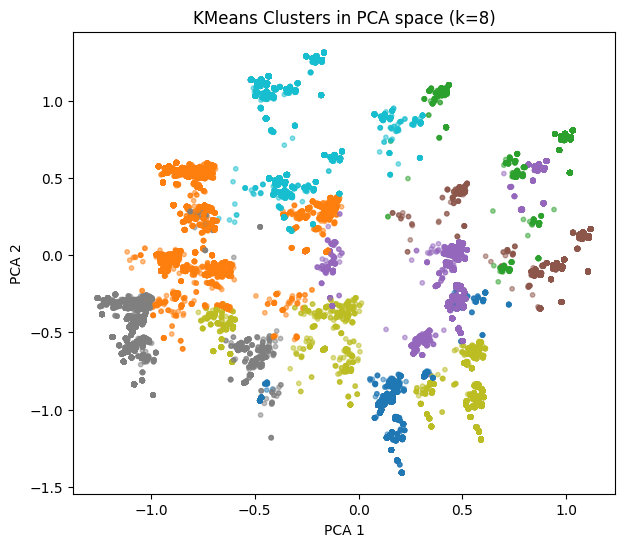

In [91]:
plt.figure(figsize=(7,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap='tab10', s=10, alpha=0.5)
plt.title(f"KMeans Clusters in PCA space (k={best_k})")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

After dimensionality reduction using PCA, K-Means clustering (k = 8) produced coherent and interpretable fashion groups. Cluster composition reflected meaningful divisions by season and gender. For example, Cluster 2 consisted primarily of men’s summer t-shirts in neutral tones, while Cluster 5 captured women’s winter accessories like heels and handbags. The remaining clusters separated by style and season transitions (e.g., men’s fall layers or women’s summer ethnicwear). These results reinforce the Apriori and MCA findings, showing that seasonality and product type are the dominant structures shaping the dataset.